In [1]:
import pandas as pd
import pickle
from datasets import Dataset
from collections import Counter
from utils import id2label, label2id
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.nn.functional import softmax
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm.notebook import tqdm as tqdm

## Constants

In [2]:
df = pd.read_json('all.json')
history_dataset = df[df.genre=='history']
titles = history_dataset['title'].to_list()
DATA = Dataset.from_pandas(history_dataset)

In [3]:
# id of paragraph where each chapter starts
titles_d = {}
for i in range(len(titles)):
    if titles[i] not in titles_d:
        titles_d[titles[i]] = i
        
titles_inv = {val:key for key, val in titles_d.items()}
titles_inv[3065] = 'A. TO THE REIGN OF JAMES I'

In [4]:
# on which paragraph and chapter each volume starts
volume_start = [('I', 0), ('XII', 708), ('XXIV', 1500), ('XXXVIII', 2245), 
                ('XLV', 2797), ('LX', 4006), ('end', 5046)]

In [5]:
volume_names = ['Volume 1. The Early History of England, Part 1', 
                'Volume 2. The Early History of England, Part 2',
                'Volume 3. The History of the House of Tudor, Part 1', 
                'Volume 4. The History of the House of Tudor, Part 2', 
                'Volume 5. The History of Great Britain, Part 1', 
                'Volume 6. The History of Great Britain, Part 2']

## Predictions

In [6]:
def predict_transformer():
    model_name = 'models/TurkuNLP/eccobert-base-cased-v1-finetuned/checkpoint-775'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id).to(device)

    tokenized_dataset = DATA.map(preprocess_function, batched=True)

    pred = torch.tensor([]).to(device)

    for line in tqdm(tokenized_dataset):
        text = line['text']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
#         predicted_class_id = logits.argmax().item()
        pred = torch.cat((pred, logits), 0)
    
    pred = softmax(pred, dim=-1)
        
    return pred.cpu()

In [7]:
def predict_logreg():

    # load
    with open('models/logreg.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('models/tfidf_vectorizer.pkl', 'rb') as f:
        vect = pickle.load(f)

    x_test = vect.transform(DATA['text'])
    pred = model.predict_proba(x_test)
    
    return pred

In [9]:
pred_logreg = predict_logreg()

In [10]:
pred_transformer = predict_transformer()

Map:   0%|          | 0/5045 [00:00<?, ? examples/s]

  0%|          | 0/5045 [00:00<?, ?it/s]

## Timelines

In [8]:
def draw_volume(num, pred):
    num = num-1
    fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')
    
    start = volume_start[num][1] # starting paragraph
    end = volume_start[num+1][1] # ending paragraph + 1

    x = np.array([i for i in range(len(pred[start:end]))]) # go through paragraphs
    for i in range(7):
        y = pred.T[i][start:end]
        y = [v if v > 0.2 else None for v in y]
        ax.scatter(x,y, label=id2label[i])

    ax.legend()
    plt.title(volume_names[num])
    
    titles = [titles_inv[el] for el in titles_inv if el >= start and el < end]
    ticks = [el-start for el in titles_inv if el >= start and el < end]
    ax.xaxis.set_ticks(ticks, labels=titles, fontsize=10)
    
    for t in ticks:
        plt.axvline(x = t)
    
    plt.show()

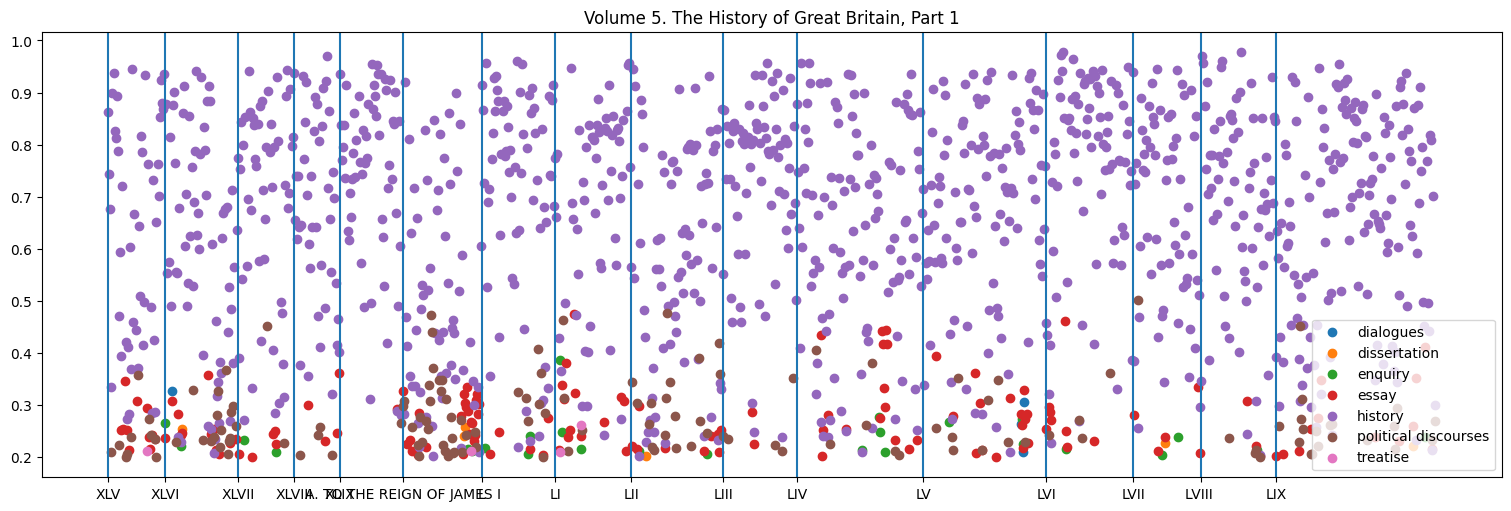

In [11]:
draw_volume(5, pred_logreg)

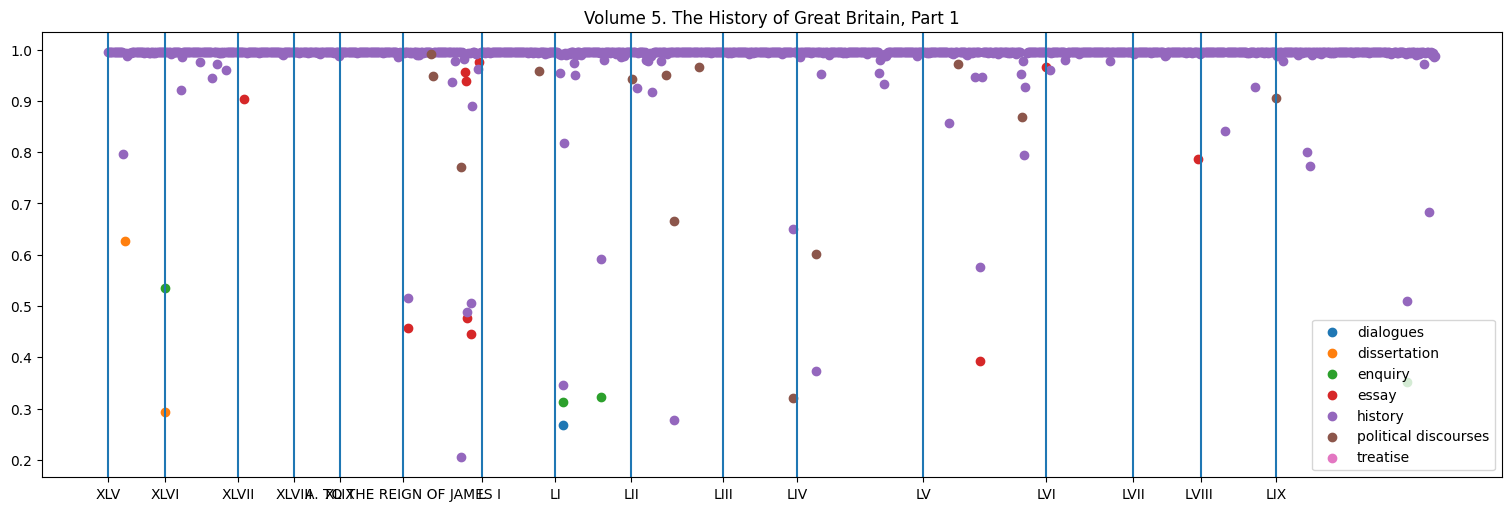

In [12]:
draw_volume(5, pred_transformer)

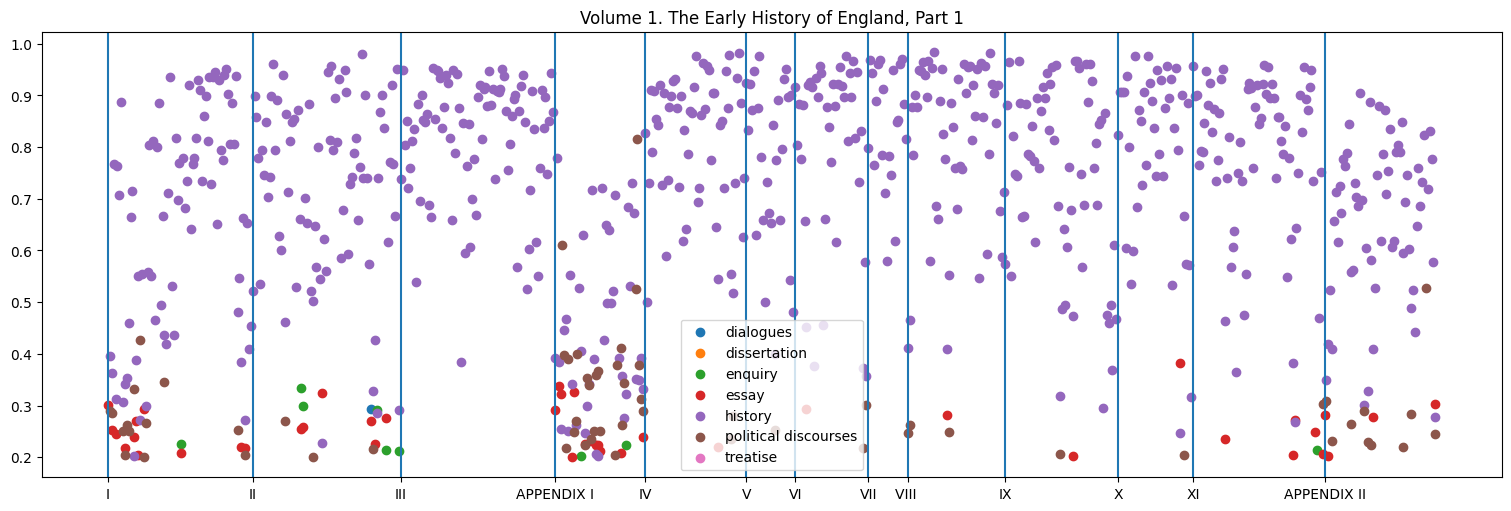

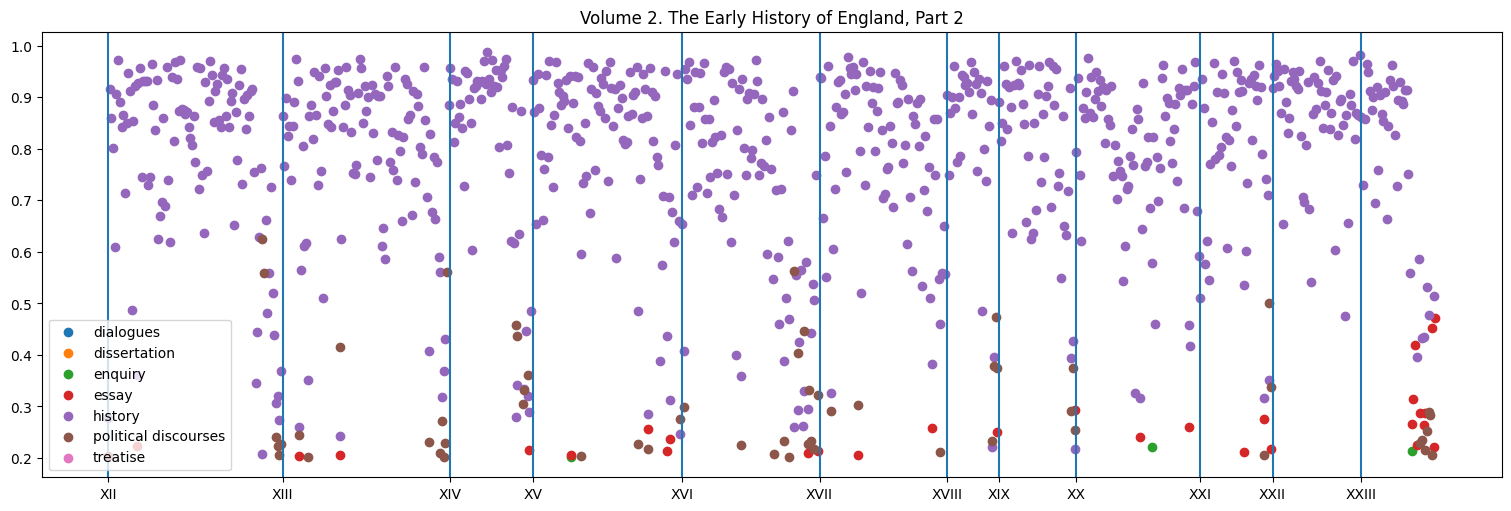

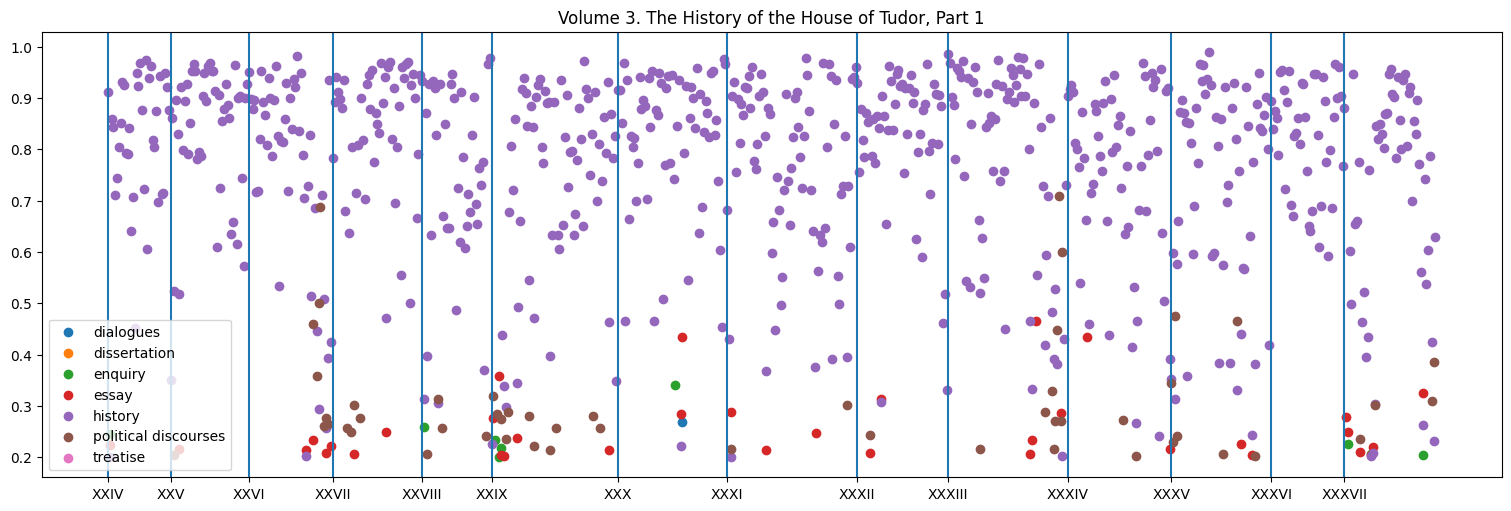

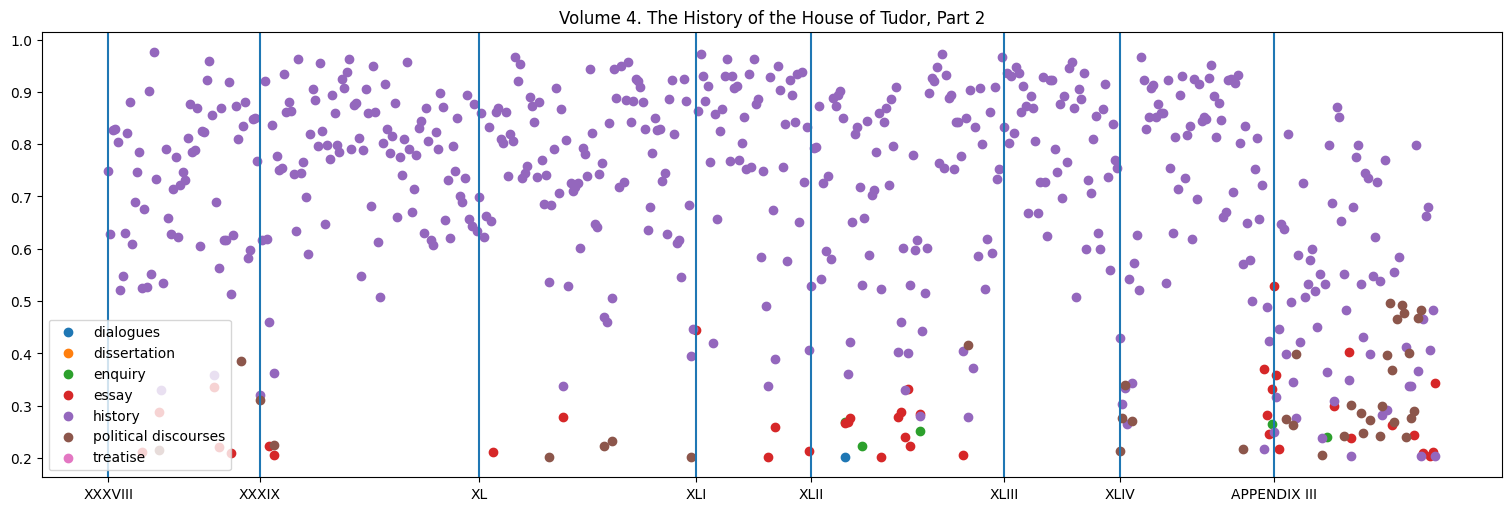

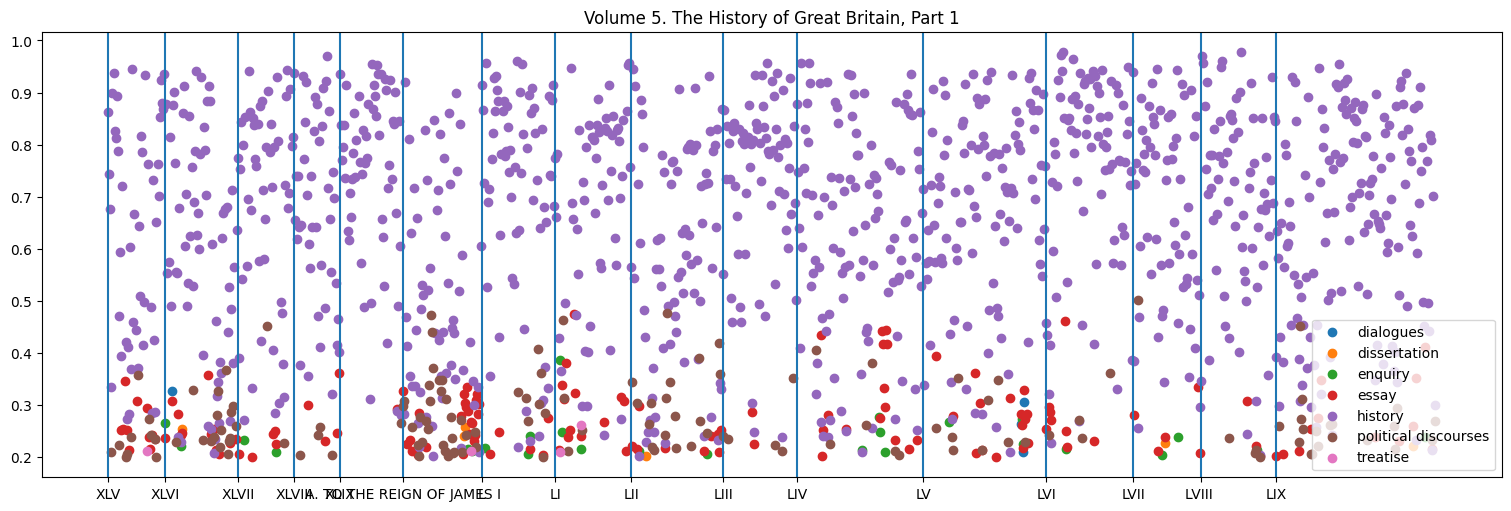

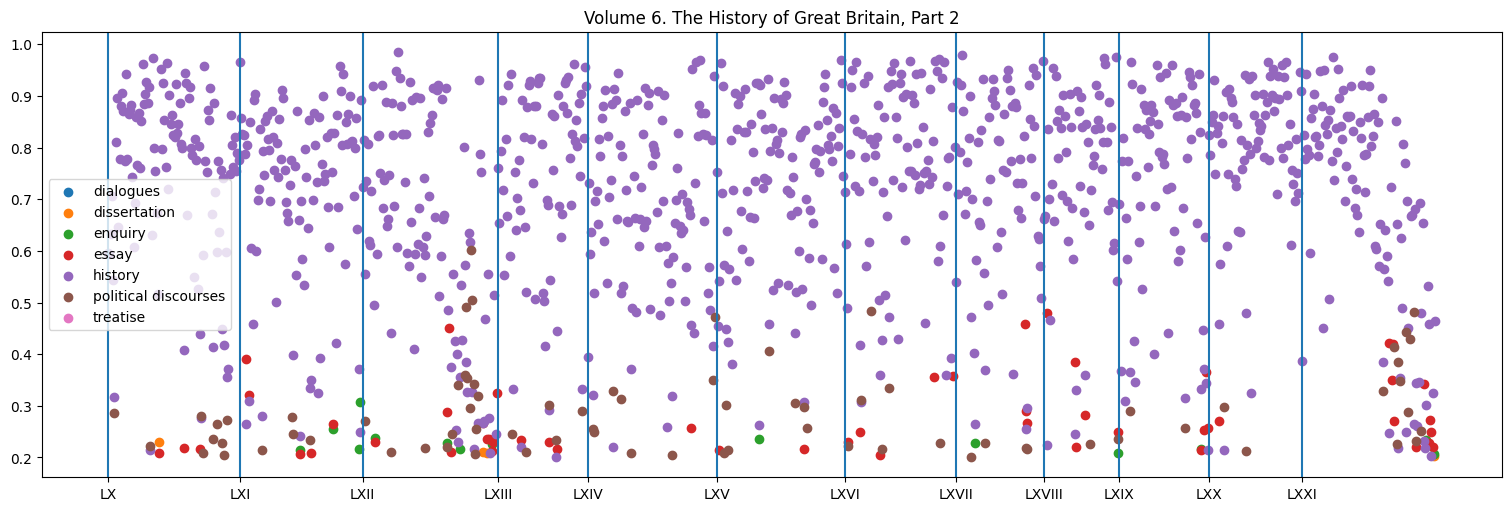

In [13]:
for i in range(1, 7):
    draw_volume(i, pred_logreg)

## Average chapter genre

Does not give us anything because the models predict history mostly

In [47]:
chapter_starts = [(key, value) for key, value in titles_inv.items()]
chapter_starts.append((5046, 'end'))

for i in range(len(chapter_starts)-1):
    chapter = chapter_starts[i]
    start = chapter[0]
    end = chapter_starts[i+1][0]
    genres = []
    for par in pred_logreg[start:end]:
        genre = par.argmax()
        genres.append(genre)
    print(chapter[1], '\t\t', id2label[max(set(genres), key=genres.count)])


I 		 history
II 		 history
III 		 history
APPENDIX I 		 history
IV 		 history
V 		 history
VI 		 history
VII 		 history
VIII  		 history
IX 		 history
X 		 history
XI 		 history
APPENDIX II 		 history
XII 		 history
XIII 		 history
XIV 		 history
XV 		 history
XVI 		 history
XVII 		 history
XVIII 		 history
XIX 		 history
XX 		 history
XXI 		 history
XXII 		 history
XXIII 		 history
XXIV 		 history
XXV 		 history
XXVI 		 history
XXVII 		 history
XXVIII 		 history
XXIX 		 history
XXX 		 history
XXXI 		 history
XXXII 		 history
XXXIII 		 history
XXXIV 		 history
XXXV 		 history
XXXVI 		 history
XXXVII 		 history
XXXVIII 		 history
XXXIX 		 history
XL 		 history
XLI 		 history
XLII 		 history
XLIII 		 history
XLIV 		 history
APPENDIX III 		 history
XLV 		 history
XLVI 		 history
XLVII 		 history
XLVIII 		 history
XLIX 		 history
A. TO THE REIGN OF JAMES I 		 history
L 		 history
LI 		 history
LII 		 history
LIII 		 history
LIV 		 history
LV 		 history
LVI 		 history
LVII 		 history
LVIII 